# Predicting the $logS$ and $logP$ values of a molecule using its MACCS fingerprints

## Setting up the notebook and importing necessary libraries

In [ ]:
!pip install rdkit

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from tqdm import tqdm
import requests
from io import StringIO

warnings.filterwarnings('ignore')

# Deep Learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Chemistry
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem
from rdkit.Chem import MACCSkeys

## Loading and Analyzing the ESol dataset

In [3]:
def load_esol_dataset():
    """Load the ESOL (Delaney) solubility dataset"""
    url = "https://raw.githubusercontent.com/deepchem/deepchem/master/datasets/delaney-processed.csv"
    response = requests.get(url)
    response.raise_for_status()

    df = pd.read_csv(StringIO(response.text))
    print(f"Loaded ESOL with {len(df)} compounds")
    print("Columns in dataset:", df.columns.tolist())
    df = df[['smiles', 'measured log solubility in mols per litre','ESOL predicted log solubility in mols per litre']]
    df.columns = ['SMILES', 'LogS','ESol_Predicted_LogS']

    # Remove invalid SMILES
    valid_smiles = []
    for smiles in df['SMILES']:
        mol = Chem.MolFromSmiles(smiles)
        valid_smiles.append(mol is not None)

    df = df[valid_smiles].reset_index(drop=True)

    return df

# Load dataset
df = load_esol_dataset()

Loaded ESOL with 1128 compounds
Columns in dataset: ['Compound ID', 'ESOL predicted log solubility in mols per litre', 'Minimum Degree', 'Molecular Weight', 'Number of H-Bond Donors', 'Number of Rings', 'Number of Rotatable Bonds', 'Polar Surface Area', 'measured log solubility in mols per litre', 'smiles']


Plotting the distribution of $logS$ values

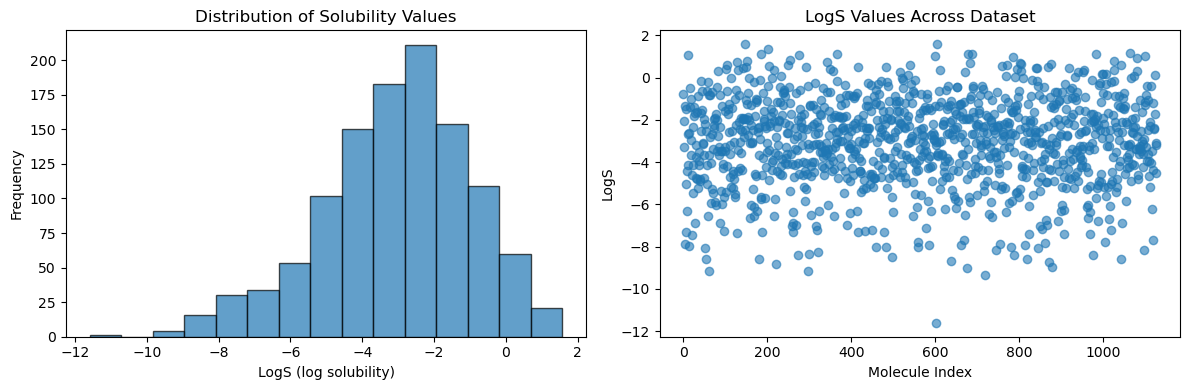

In [4]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(df['LogS'], bins=15, alpha=0.7, edgecolor='black')
plt.xlabel('LogS (log solubility)')
plt.ylabel('Frequency')
plt.title('Distribution of Solubility Values')

plt.subplot(1, 2, 2)
plt.scatter(range(len(df)), df['LogS'], alpha=0.6)
plt.xlabel('Molecule Index')
plt.ylabel('LogS')
plt.title('LogS Values Across Dataset')
plt.tight_layout()
plt.show()

Plotting the distribution of $logP$ values

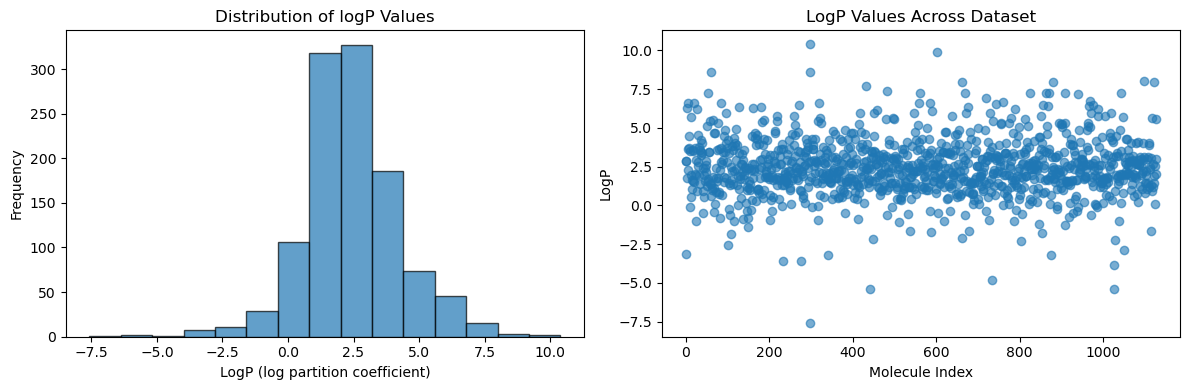

In [5]:
logp_values =[]
for smile in df['SMILES']:
    mol = Chem.MolFromSmiles(smile)
    if mol:
        logp = Descriptors.MolLogP(mol)
        logp_values.append(logp)
    else:
        logp_values.append(np.nan)
logp_values = np.array(logp_values)
df['LogP'] = logp_values

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(df['LogP'], bins=15, alpha=0.7, edgecolor='black')
plt.xlabel('LogP (log partition coefficient)')
plt.ylabel('Frequency')
plt.title('Distribution of logP Values')

plt.subplot(1, 2, 2)
plt.scatter(range(len(df)), df['LogP'], alpha=0.6)
plt.xlabel('Molecule Index')
plt.ylabel('LogP')
plt.title('LogP Values Across Dataset')
plt.tight_layout()
plt.show()

## Setting Hyperparameters and Generating Fingerprints

In [6]:
BATCH_SIZE = 1 #batch size for training (can try : 16,32,64)
NUM_EPOCHS = 100 #number of epochs
WEIGHT_DECAY = 1e-3 #coefficient to be used in regularisation
LEARNING_RATE = 1e-3 #learning rate
PATIENCE = 3 #number of epochs to wait before reducing learning rate
FACTOR = 0.5 #factor by which to reduce learning rate
EARLY_STOPPING = 10 #number of epochs to wait before stopping training if validation loss does not improve
DROPOUT = 0.2 #dropout rate for regularisation

Generating MACCS fingerprints with the help of RDkit. MACCS (Molecular ACCess System) fingerprints are a set of 166 predefined structural keys used in cheminformatics to digitally represent molecules as binary strings (0s and 1s), indicating the presence or absence of specific chemical fragments, making them excellent for comparing molecules and searching chemical databases

In [7]:
maccs = []

for smile in df["SMILES"]:
    mol = Chem.MolFromSmiles(smile)
    maccs_fp = np.array(MACCSkeys.GenMACCSKeys(mol))
    maccs.append(maccs_fp)

df["maccs"] = maccs

### Visualizing frequency of number of bits turned on in MACCS fingerprints. This plot will give us some insight into the dataset

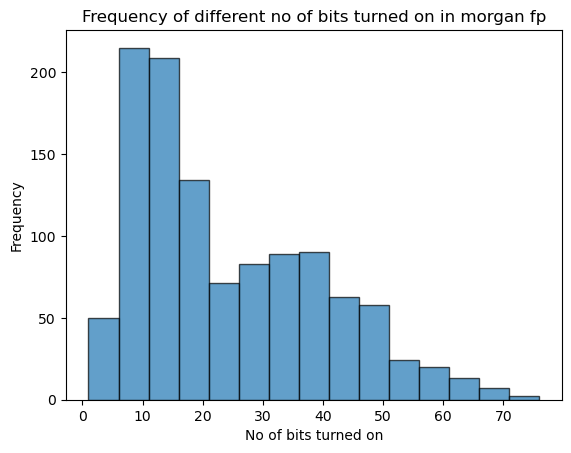

In [11]:
num_ones = [] #list containing no of ones in morgan fp of molecules
for _,row in df.iterrows():
    num_ones.append(np.sum(row['maccs']))
plt.title("Frequency of different no of bits turned on in morgan fp")
plt.hist(num_ones,bins=15,alpha=0.7,edgecolor='black')
plt.ylabel("Frequency")
plt.xlabel("No of bits turned on")
plt.show()

### Defining a PyTorch `Dataset` class and instantiating the `Dataloaders`

In [12]:
class FPDataset(Dataset):
    def __init__(self,x,y):
        self.x = x
        self.y = y
    def __len__(self):
        return len(self.x)
    def __getitem__(self, index):
        return self.x[index],self.y[index]
    
X_train, X_test, y_train, y_test = train_test_split(
    df['maccs'].values, df[['LogS','LogP']].values, #as we are predicting both LogS and LogP
    test_size=0.2, random_state=42
)

train_dataset = FPDataset(X_train,y_train)
test_dataset = FPDataset(X_test,y_test)
train_loader = DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle = True)
test_loader = DataLoader(test_dataset,batch_size=BATCH_SIZE,shuffle = False)

# Defining a 2-layer MLP model, setting the loss criterion, optimizer and instantiating the model

In [13]:
class MLP(nn.Module):
    def __init__(self,input_channels=167,num_classes=2):
        super(MLP, self).__init__()
        self.regressor = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_channels,84), #hidden layer 1
            nn.ReLU(),
            nn.Dropout(DROPOUT), #dropout for regularisation
            nn.Linear(84,42), #hidden layer 2
            nn.ReLU(),
            nn.Dropout(DROPOUT), #dropout for regularisation
            nn.Linear(42,2),
        )
    def forward(self,x):
        y = self.regressor(x)
        return y

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MLP().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE,weight_decay=WEIGHT_DECAY) #weight decay for regularisation
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=PATIENCE, factor=FACTOR) #reduce learning rate by 0.5 if validation loss does not improve for 3 epochs


## Training the regression model

In [15]:
def train_model_regression(model,train_loader,test_loader,num_epochs=NUM_EPOCHS):
    train_losses = [] #list to store training losses
    train_logs_losses = [] #list to store training losses for logs
    train_logp_losses = [] #list to store training losses for logp

    all_predictions = [] #list to store predictions
    all_logs = [] #list to store true values

    test_losses = [] #list to store test losses
    test_logs_losses = [] #list to store test losses for logs
    test_logp_losses = [] #list to store test losses for logP
    test_r2_scores = [] #list to store test r2 scores - r2 score is a measure of how much of the veriance in the target variable is explained by the model

    early_stopping_counter = 0  # Counter for early stopping

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_loss_logS = 0.0
        running_loss_logP = 0.0

        for fp,logs in tqdm(train_loader,desc="training"):
            logs = logs.float().to(device)
            fp = fp.float().to(device)

            optimizer.zero_grad() # Zero the gradients,or else they will keep accumulating
            outputs = model(fp)

            loss_logS = criterion(outputs[:, 0], logs[:, 0])  # LogS loss
            loss_logP = criterion(outputs[:, 1], logs[:, 1])  # LogP loss
            loss = loss_logS + loss_logP  # Total loss
            loss.backward()

            optimizer.step()

            running_loss += loss.item()
            running_loss_logS += loss_logS.item()
            running_loss_logP += loss_logP.item()

        train_loss = running_loss / len(train_loader)
        train_loss_logS = running_loss_logS / len(train_loader)
        train_loss_logP = running_loss_logP / len(train_loader)

        model.eval() #disables dropout and other regularization

        test_loss = 0.0
        test_loss_logS = 0.0
        test_loss_logP = 0.0

        all_predictions = []
        all_logs = []

        with torch.no_grad():
            for fp,logs in tqdm(test_loader,desc="testing"):
                logs = logs.float().to(device)
                fp = fp.float().to(device)
                outputs = model(fp)

                loss_logS = criterion(outputs[:, 0], logs[:, 0])  # LogS loss
                loss_logP = criterion(outputs[:, 1], logs[:, 1])  # LogP loss
                loss = loss_logS + loss_logP  # Total loss
                test_loss += loss.item()
                test_loss_logS += loss_logS.item()
                test_loss_logP += loss_logP.item()

                all_predictions.extend(outputs.cpu().numpy())
                all_logs.extend(logs.cpu().numpy())

            test_loss = test_loss / len(test_loader)
            test_loss_logS = test_loss_logS / len(test_loader)
            test_loss_logP = test_loss_logP / len(test_loader)
            r2 = r2_score(all_logs, all_predictions)

            scheduler.step(test_loss)

            if(epoch>0):
                if test_loss > test_losses[-1]:  # Check if the test loss has increased
                    early_stopping_counter += 1
                elif abs(test_loss - test_losses[-1]) < 1e-4:  # Check if the test loss has not changed significantly
                    early_stopping_counter += 1
                else:
                    early_stopping_counter = 0
                
            if early_stopping_counter >= EARLY_STOPPING:
                break
            
            train_losses.append(train_loss)
            test_losses.append(test_loss)
            test_r2_scores.append(r2)
            train_logs_losses.append(train_loss_logS)
            train_logp_losses.append(train_loss_logP)
            test_logs_losses.append(test_loss_logS)
            test_logp_losses.append(test_loss_logP)

            print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, '
              f'Test Loss: {test_loss:.4f}, '
              f'Test R²: {r2:.4f}, ')
    return train_losses, test_losses, test_r2_scores, train_logs_losses, train_logp_losses, test_logs_losses, test_logp_losses


In [16]:
train_losses, test_losses, test_r2_scores,train_logs_losses,train_logp_losses, test_logs_losses, test_logp_losses=train_model_regression(model,train_loader,test_loader,100)

testing: 100%|██████████| 226/226 [00:00<00:00, 1646.44it/s]


Epoch [1/100], Train Loss: 5.3933, Test Loss: 3.1005, Test R²: 0.6305, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1652.90it/s]


Epoch [2/100], Train Loss: 3.0692, Test Loss: 2.3315, Test R²: 0.7251, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1690.73it/s]


Epoch [3/100], Train Loss: 2.6699, Test Loss: 2.5277, Test R²: 0.7029, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1798.67it/s]


Epoch [4/100], Train Loss: 2.4915, Test Loss: 2.3580, Test R²: 0.7218, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1665.12it/s]


Epoch [5/100], Train Loss: 2.3165, Test Loss: 2.0552, Test R²: 0.7581, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1751.69it/s]


Epoch [6/100], Train Loss: 2.4194, Test Loss: 2.4514, Test R²: 0.7091, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1928.30it/s]


Epoch [7/100], Train Loss: 2.2011, Test Loss: 2.0193, Test R²: 0.7625, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1925.90it/s]


Epoch [8/100], Train Loss: 2.1695, Test Loss: 1.9700, Test R²: 0.7689, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1839.60it/s]


Epoch [9/100], Train Loss: 1.9484, Test Loss: 2.0021, Test R²: 0.7637, 


testing: 100%|██████████| 226/226 [00:00<00:00, 2333.77it/s]


Epoch [10/100], Train Loss: 2.0895, Test Loss: 2.0032, Test R²: 0.7657, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1827.17it/s]


Epoch [11/100], Train Loss: 1.8325, Test Loss: 2.3536, Test R²: 0.7218, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1746.98it/s]


Epoch [12/100], Train Loss: 1.9265, Test Loss: 2.0889, Test R²: 0.7527, 


testing: 100%|██████████| 226/226 [00:00<00:00, 2294.34it/s]


Epoch [13/100], Train Loss: 1.6819, Test Loss: 1.6575, Test R²: 0.8048, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1635.93it/s]


Epoch [14/100], Train Loss: 1.5831, Test Loss: 1.8979, Test R²: 0.7765, 


testing: 100%|██████████| 226/226 [00:00<00:00, 2310.63it/s]


Epoch [15/100], Train Loss: 1.3684, Test Loss: 1.7787, Test R²: 0.7911, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1750.20it/s]


Epoch [16/100], Train Loss: 1.5344, Test Loss: 1.7780, Test R²: 0.7905, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1761.40it/s]


Epoch [17/100], Train Loss: 1.5429, Test Loss: 1.6043, Test R²: 0.8112, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1695.89it/s]


Epoch [18/100], Train Loss: 1.4326, Test Loss: 1.5518, Test R²: 0.8173, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1636.09it/s]


Epoch [19/100], Train Loss: 1.4182, Test Loss: 1.6568, Test R²: 0.8048, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1685.44it/s]


Epoch [20/100], Train Loss: 1.4137, Test Loss: 1.6516, Test R²: 0.8058, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1616.43it/s]


Epoch [21/100], Train Loss: 1.4411, Test Loss: 1.7535, Test R²: 0.7939, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1635.46it/s]


Epoch [22/100], Train Loss: 1.3677, Test Loss: 1.7470, Test R²: 0.7942, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1974.40it/s]


Epoch [23/100], Train Loss: 1.2278, Test Loss: 1.6407, Test R²: 0.8071, 


testing: 100%|██████████| 226/226 [00:00<00:00, 2332.94it/s]


Epoch [24/100], Train Loss: 1.2518, Test Loss: 1.7465, Test R²: 0.7950, 


testing: 100%|██████████| 226/226 [00:00<00:00, 2343.57it/s]


Epoch [25/100], Train Loss: 1.2766, Test Loss: 1.6673, Test R²: 0.8045, 


testing: 100%|██████████| 226/226 [00:00<00:00, 2334.36it/s]


Epoch [26/100], Train Loss: 1.2358, Test Loss: 1.6561, Test R²: 0.8051, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1754.94it/s]


Epoch [27/100], Train Loss: 1.2970, Test Loss: 1.6499, Test R²: 0.8056, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1960.58it/s]


Epoch [28/100], Train Loss: 1.1648, Test Loss: 1.6871, Test R²: 0.8020, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1680.12it/s]


Epoch [29/100], Train Loss: 1.2459, Test Loss: 1.6631, Test R²: 0.8044, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1642.47it/s]


Epoch [30/100], Train Loss: 1.1734, Test Loss: 1.5952, Test R²: 0.8124, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1869.87it/s]


Epoch [31/100], Train Loss: 1.1474, Test Loss: 1.6532, Test R²: 0.8056, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1926.69it/s]


Epoch [32/100], Train Loss: 1.1388, Test Loss: 1.6459, Test R²: 0.8066, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1776.59it/s]


Epoch [33/100], Train Loss: 1.1831, Test Loss: 1.6496, Test R²: 0.8061, 


testing: 100%|██████████| 226/226 [00:00<00:00, 2145.06it/s]


Epoch [34/100], Train Loss: 1.1541, Test Loss: 1.6759, Test R²: 0.8030, 


testing: 100%|██████████| 226/226 [00:00<00:00, 2309.28it/s]


Epoch [35/100], Train Loss: 1.1466, Test Loss: 1.6250, Test R²: 0.8091, 


testing: 100%|██████████| 226/226 [00:00<00:00, 2297.43it/s]


Epoch [36/100], Train Loss: 1.1461, Test Loss: 1.6344, Test R²: 0.8080, 


testing: 100%|██████████| 226/226 [00:00<00:00, 2297.66it/s]


Epoch [37/100], Train Loss: 1.1328, Test Loss: 1.6184, Test R²: 0.8098, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1844.06it/s]


Epoch [38/100], Train Loss: 1.2326, Test Loss: 1.6453, Test R²: 0.8068, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1640.56it/s]


Epoch [39/100], Train Loss: 1.0413, Test Loss: 1.6307, Test R²: 0.8085, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1670.42it/s]


Epoch [40/100], Train Loss: 1.1269, Test Loss: 1.6432, Test R²: 0.8069, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1952.62it/s]


Epoch [41/100], Train Loss: 1.0805, Test Loss: 1.6298, Test R²: 0.8085, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1759.52it/s]


Epoch [42/100], Train Loss: 1.1776, Test Loss: 1.6392, Test R²: 0.8075, 


testing: 100%|██████████| 226/226 [00:00<00:00, 2212.80it/s]


Epoch [43/100], Train Loss: 1.0979, Test Loss: 1.6393, Test R²: 0.8074, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1713.88it/s]


Epoch [44/100], Train Loss: 1.1492, Test Loss: 1.6353, Test R²: 0.8079, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1711.49it/s]


Epoch [45/100], Train Loss: 1.0446, Test Loss: 1.6392, Test R²: 0.8074, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1937.64it/s]


Epoch [46/100], Train Loss: 1.1131, Test Loss: 1.6422, Test R²: 0.8071, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1625.57it/s]


Epoch [47/100], Train Loss: 1.1123, Test Loss: 1.6371, Test R²: 0.8077, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1670.72it/s]


Epoch [48/100], Train Loss: 1.0755, Test Loss: 1.6365, Test R²: 0.8077, 


testing: 100%|██████████| 226/226 [00:00<00:00, 2278.03it/s]


Epoch [49/100], Train Loss: 1.2257, Test Loss: 1.6353, Test R²: 0.8079, 


testing: 100%|██████████| 226/226 [00:00<00:00, 2301.48it/s]


Epoch [50/100], Train Loss: 1.1228, Test Loss: 1.6330, Test R²: 0.8082, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1744.51it/s]


Epoch [51/100], Train Loss: 1.1458, Test Loss: 1.6323, Test R²: 0.8082, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1691.75it/s]


Epoch [52/100], Train Loss: 1.0905, Test Loss: 1.6307, Test R²: 0.8084, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1783.12it/s]


Epoch [53/100], Train Loss: 1.1476, Test Loss: 1.6287, Test R²: 0.8087, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1958.78it/s]


Epoch [54/100], Train Loss: 1.1334, Test Loss: 1.6298, Test R²: 0.8085, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1608.82it/s]


Epoch [55/100], Train Loss: 1.0200, Test Loss: 1.6289, Test R²: 0.8087, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1819.29it/s]


Epoch [56/100], Train Loss: 1.1507, Test Loss: 1.6285, Test R²: 0.8087, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1583.98it/s]


Epoch [57/100], Train Loss: 1.0809, Test Loss: 1.6284, Test R²: 0.8087, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1735.96it/s]


Epoch [58/100], Train Loss: 1.1276, Test Loss: 1.6281, Test R²: 0.8087, 


testing: 100%|██████████| 226/226 [00:00<00:00, 2146.78it/s]


Epoch [59/100], Train Loss: 1.1496, Test Loss: 1.6277, Test R²: 0.8088, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1658.29it/s]


Epoch [60/100], Train Loss: 1.0909, Test Loss: 1.6278, Test R²: 0.8088, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1782.75it/s]


Epoch [61/100], Train Loss: 1.0650, Test Loss: 1.6278, Test R²: 0.8088, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1624.41it/s]


Epoch [62/100], Train Loss: 1.1301, Test Loss: 1.6281, Test R²: 0.8087, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1821.06it/s]


Epoch [63/100], Train Loss: 1.1151, Test Loss: 1.6280, Test R²: 0.8088, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1601.51it/s]


Epoch [64/100], Train Loss: 1.1141, Test Loss: 1.6280, Test R²: 0.8088, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1782.16it/s]


Epoch [65/100], Train Loss: 1.1829, Test Loss: 1.6279, Test R²: 0.8088, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1827.08it/s]


Epoch [66/100], Train Loss: 1.0657, Test Loss: 1.6279, Test R²: 0.8088, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1759.26it/s]


Epoch [67/100], Train Loss: 1.1630, Test Loss: 1.6280, Test R²: 0.8088, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1667.58it/s]


Epoch [68/100], Train Loss: 1.0555, Test Loss: 1.6279, Test R²: 0.8088, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1745.73it/s]


Epoch [69/100], Train Loss: 1.0201, Test Loss: 1.6279, Test R²: 0.8088, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1667.77it/s]


Epoch [70/100], Train Loss: 1.0722, Test Loss: 1.6279, Test R²: 0.8088, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1684.14it/s]


Epoch [71/100], Train Loss: 1.1232, Test Loss: 1.6279, Test R²: 0.8088, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1765.79it/s]


Epoch [72/100], Train Loss: 1.1868, Test Loss: 1.6278, Test R²: 0.8088, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1992.99it/s]


## Evaluating model performance with Visualizations

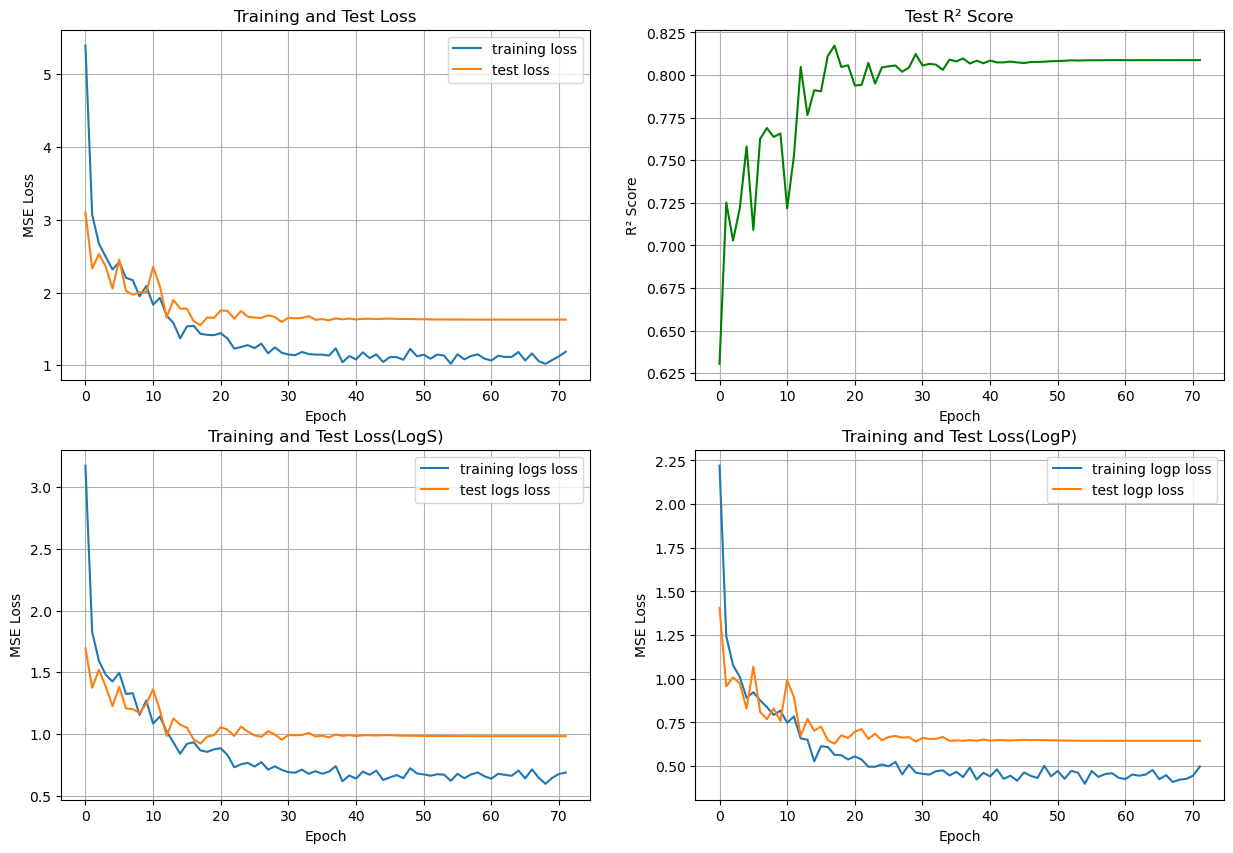

In [17]:
plt.figure(figsize=(15, 10))
plt.subplot(2,2,1)
plt.plot(train_losses,label="training loss")
plt.plot(test_losses,label = "test loss")
plt.title('Training and Test Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(test_r2_scores, label='Test R²', color='green')
plt.title('Test R² Score')
plt.xlabel('Epoch')
plt.ylabel('R² Score')
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(train_logs_losses,label="training logs loss")
plt.plot(test_logs_losses,label = "test logs loss")
plt.title('Training and Test Loss(LogS)')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(train_logp_losses,label="training logp loss")
plt.plot(test_logp_losses,label = "test logp loss")
plt.title('Training and Test Loss(LogP)')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)

### Comparing Test Set predictions with Actual Values

final evaluation: 100%|██████████| 226/226 [00:00<00:00, 3392.38it/s]


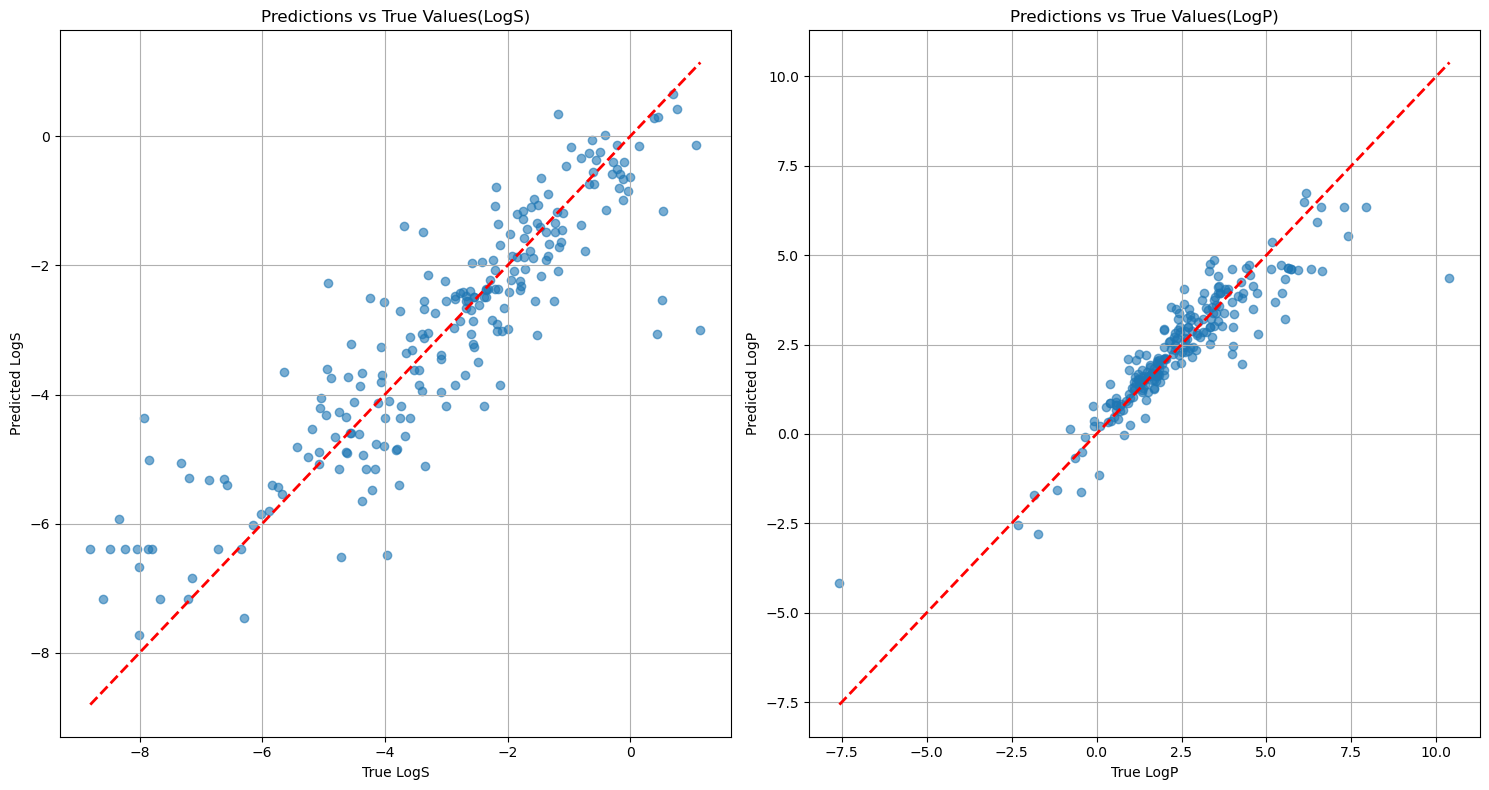

In [18]:
model.eval()
final_predictions = []
final_labels = []

with torch.no_grad():
    for fp,logs in tqdm(test_loader,desc="final evaluation"):
        logs = logs.float().to(device)
        fp = fp.float().to(device)
        outputs = model(fp)

        final_predictions.extend(outputs.cpu().numpy())
        final_labels.extend(logs.cpu().numpy())

final_predictions = np.array(final_predictions)
final_labels = np.array(final_labels)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.scatter(final_labels[:,0], final_predictions[:,0], alpha=0.6)
plt.plot([min(final_labels[:,0]), max(final_labels[:,0])],
         [min(final_labels[:,0]), max(final_labels[:,0])], 'r--', lw=2)
plt.xlabel('True LogS')
plt.ylabel('Predicted LogS')
plt.title('Predictions vs True Values(LogS)')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(final_labels[:,1], final_predictions[:,1], alpha=0.6)
plt.plot([min(final_labels[:,1]), max(final_labels[:,1])],
         [min(final_labels[:,1]), max(final_labels[:,1])], 'r--', lw=2)
plt.xlabel('True LogP')
plt.ylabel('Predicted LogP')
plt.title('Predictions vs True Values(LogP)')
plt.grid(True)

plt.tight_layout()
plt.show()